# Predicting Japanese pitch accent

I made a model that predict Japanese pitch accent that you can try out here: https://huggingface.co/spaces/mizoru/Japanese_pitch

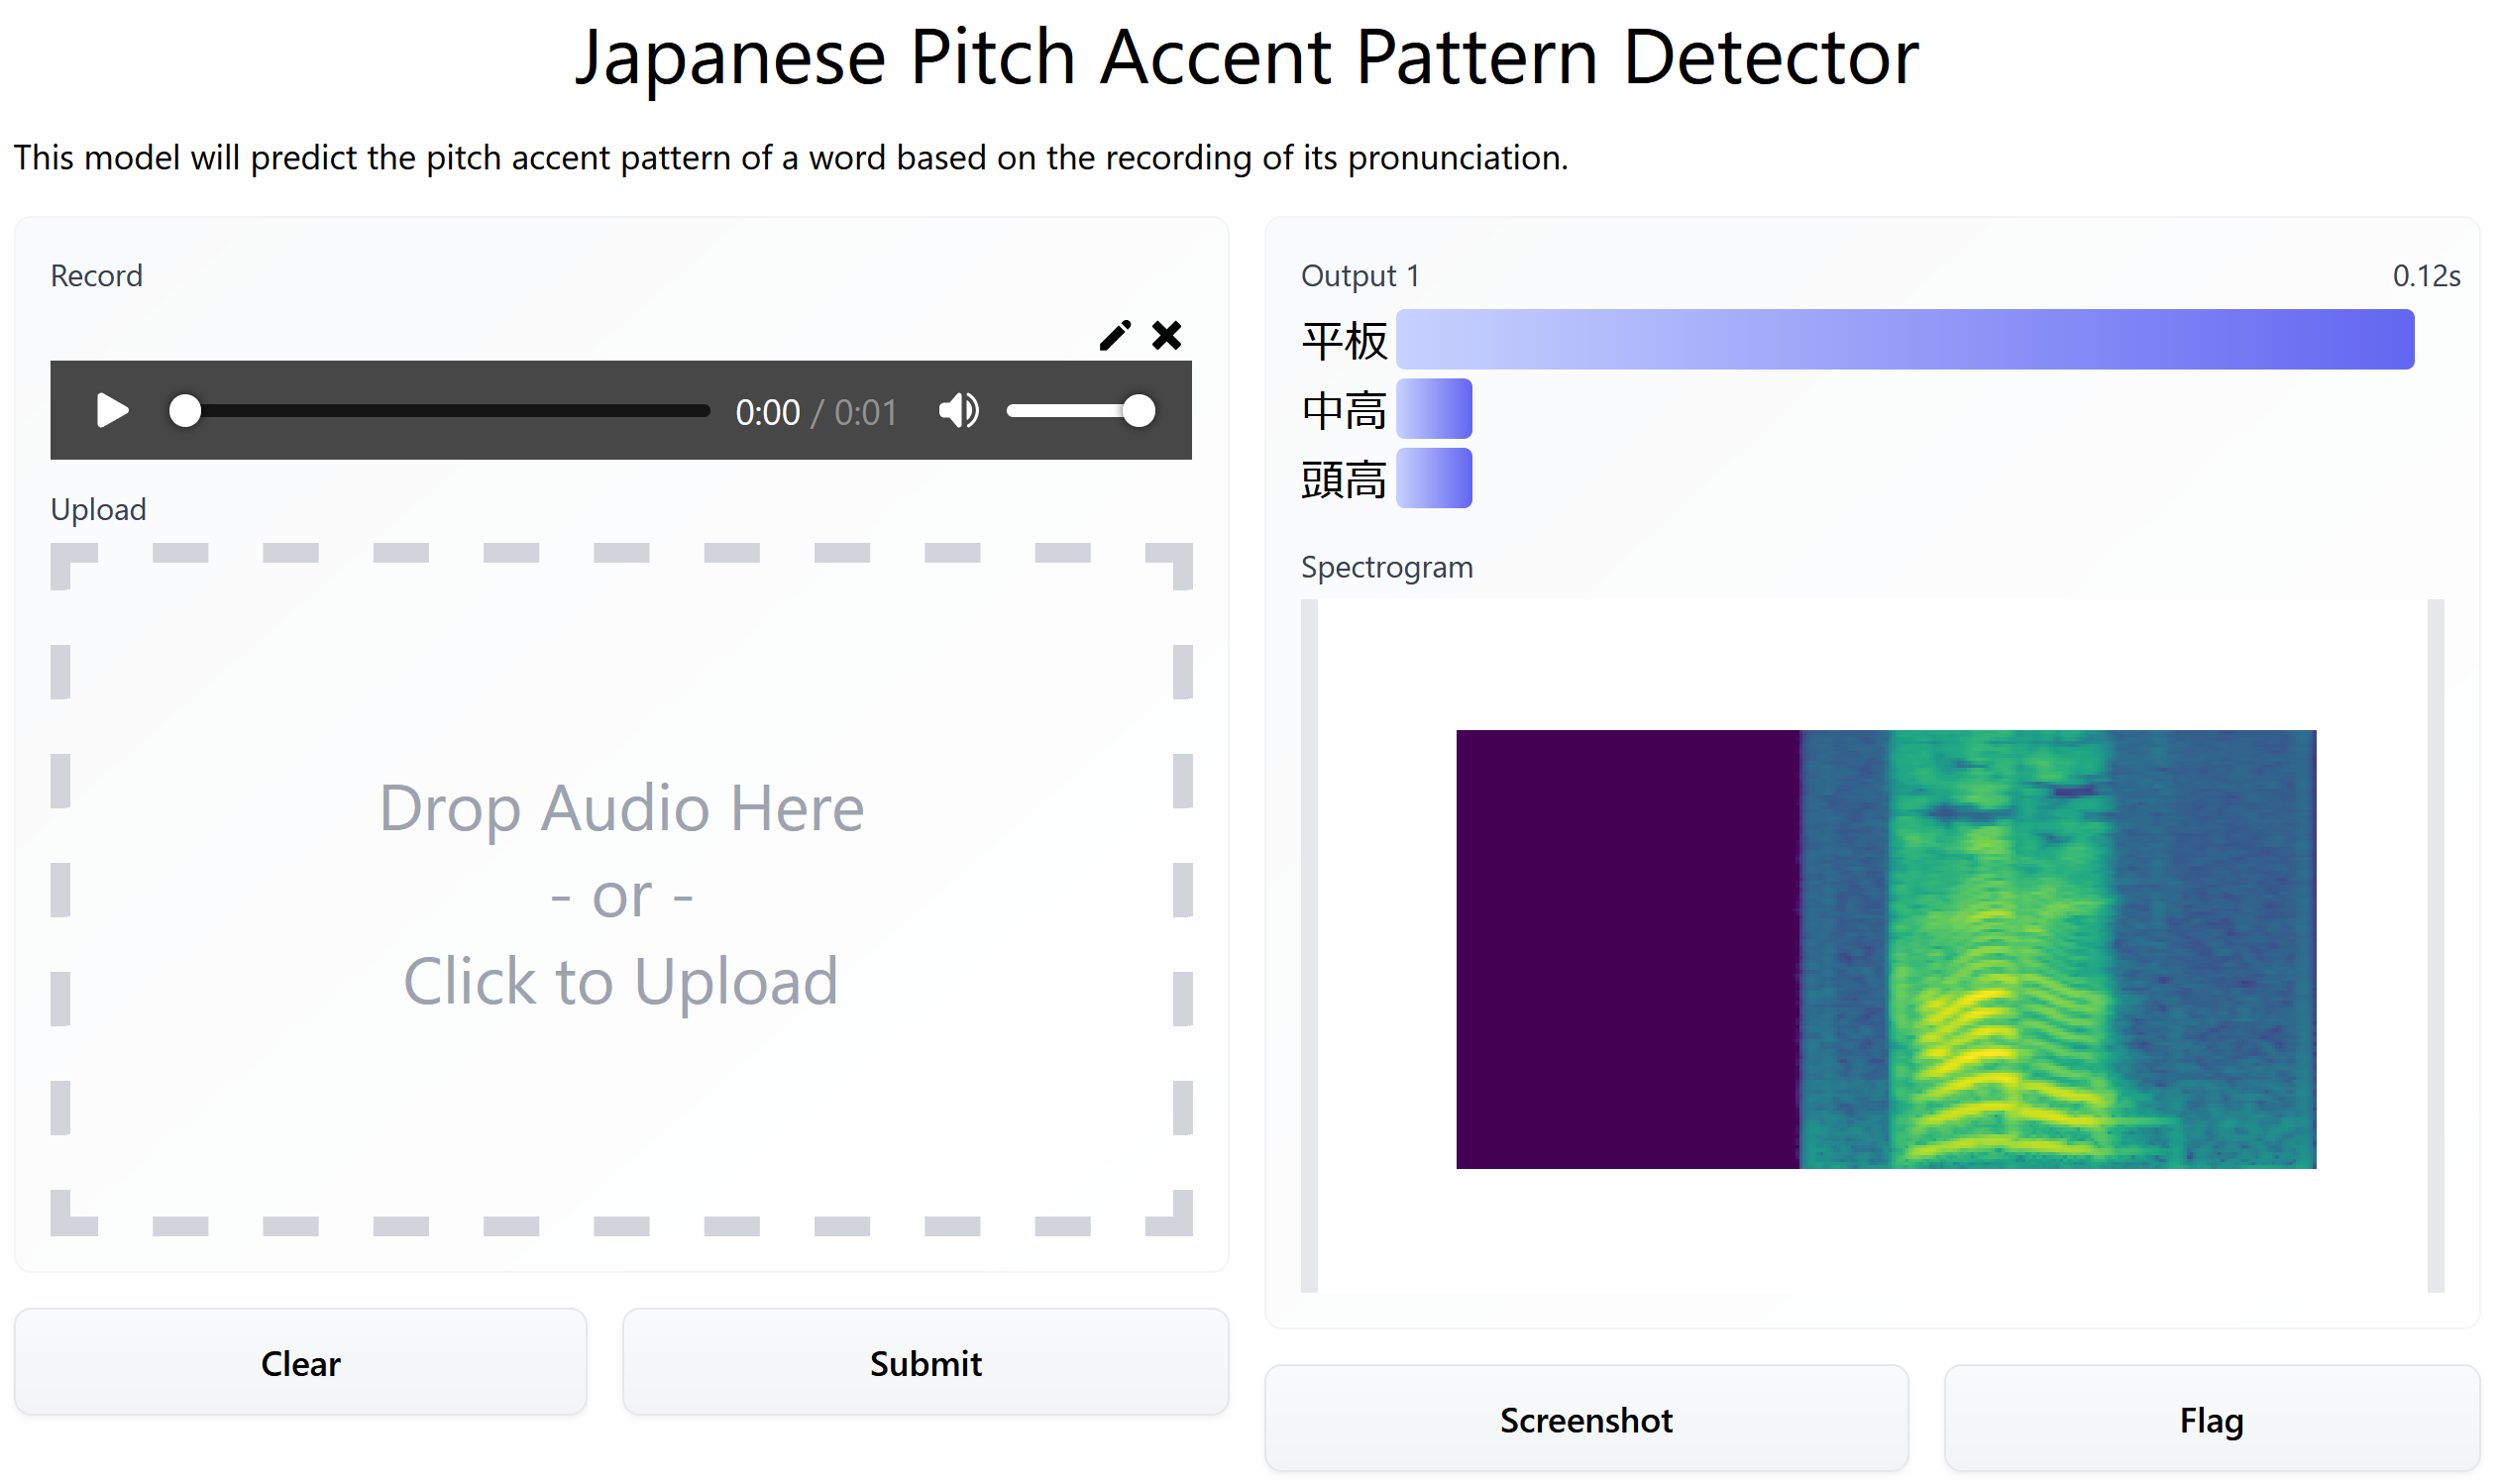

But what is pitch accent and how did I make this?

## Pitch accent

Let's look at two Japanese words: 飴 "candy" and 雨 "rain". They're both spelled _ame_, but they don't sound the same. Let's listen to how they're pronounced!

In [63]:
# hide_input
Audio("あめー飴.mp3")

In [69]:
# hide_input
Audio("あめー雨.mp3")

Can you tell the difference? The second word has a drop in pitch after the first vowel.

This is pitch accent. In pitch-accent languages one syllable of the word can be marked with contrasting pitch, rather than by loudness or length as in languages with stress accent. Various pitch accent systems exist in many languages, in Swedish, Norwegian, Serbo-Croatian and Lithuanian among others. In fact, pitch accent is reconstructed for Proto-Indo-European, the proto-language of most of the languages of Europe.

## Japanese pitch accent

In Japanese pitch accent is caracterized by a drop in pitch. The mora preceding the drop is said to have the accent. So the pitch accent of a word can be described with one number, designating the mora that carries the accent. The word 雨 "rain" has the accent on the first mora, the pitch accent of it would be written down as 「１」. But there's a different way to classify words by pitch accent.

When the first mora a word carries the accent, the pitch accent pattern of the word is 頭高 _atamadaka_, literally "head-high". If the pitch drops after that the pitch accent pattern is 中高 _nakadaka_, "middle-high". Many words in Japanese don't have a drop in pitch, these are called 平板 _heiban_, "flat"

Let's listen to some examples.

Atamadaka:

In [67]:
# hide_input
Audio("熱くない.mp3")

Nakadaka:

In [65]:
# hide_input
Audio("大丈夫な.mp3")

Heiban:

In [66]:
# hide_input
Audio("代わる.mp3")

In some words, the drop in pitch is apparent only if there is a particle attached to the word. In these words the last mora of the word is accented, so the particle attached after it is low. These words have the pitch accent pattern 尾高 _odaka_, "tail-high". In practice, the phonetic word sounds heiban when there's no particle attached, and sounds nakadaka, when there is. So we're not going to use these for training.

## Data

I thank [Yoga](https://www.youtube.com/c/ImmersewithMigaku/) from [Migaku](https://www.migaku.io/) for making this data available.

Let's import the libraries we're going to be using to make the model.

In [3]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *

Here are fastai, fastaudio and torchaudio versions accordingly:

In [2]:
#hide_iput
import fastai
import fastaudio
import torchaudio
fastai.__version__, fastaudio.__version__,torchaudio.__version__

('2.3.1', '1.0.2', '0.8.1')

Let's take a look at our data

In [72]:
Path("dict1").ls()

(#80120) [Path('dict1/α粒子.yomi00013233_063E.mp3'),Path('dict1/α線.yomi0001323E_0162.mp3'),Path('dict1/γ.yomi00013247_04EE.mp3'),Path('dict1/γ線.yomi0001324B_0100.mp3'),Path('dict1/λ.yomi00013255_034C.mp3'),Path('dict1/π.yomi0001325F_0238.mp3'),Path('dict1/σ.yomi00013265_07D4.mp3'),Path('dict1/ω.yomi0001326D_05E0.mp3'),Path('dict1/○×式.yomi00013273_004A.mp3'),Path('dict1/ああ.yomi00013280_030E.mp3')...]

In [73]:
Path("dict2").ls()

(#84356) [Path('dict2/あくどい-2830_1_1_male.mp3'),Path('dict2/あくどい-2830_2_1_female.mp3'),Path('dict2/あくどい-2830_2_1_male.mp3'),Path('dict2/あくどいです-2830_3_1_female.mp3'),Path('dict2/あくどいです-2830_3_1_male.mp3'),Path('dict2/あくどかった-2830_6_1_female.mp3'),Path('dict2/あくどかった-2830_6_1_male.mp3'),Path('dict2/あくどかった-2830_6_2_female.mp3'),Path('dict2/あくどかった-2830_6_2_male.mp3'),Path('dict2/あくどく-2830_4_1_female.mp3')...]

In [4]:
dict1 = pd.read_csv('dict1_labels.csv')

In [53]:
dict1

,path,pattern,kana,morae,drop,type
0,dict1/ある.yomi000142BB_0596.mp3,頭高,アル,2,1,dict1
1,dict1/思う.yomi0006C617_043A.mp3,中高,オモウ,3,2,dict1
2,dict1/など.yomi000240B7_0028.mp3,頭高,ナド,2,1,dict1
3,dict1/私.yomi00092F63_0072.mp3,平板,ワタくシ,4,0,dict1
4,dict1/見る.yomi000A41BD_001E.mp3,頭高,ミル,2,1,dict1
...,...,...,...,...,...,...
79480,dict1/捨てがな_捨て仮名.yomi00072538_06BE.mp3,平板,すテカ゚ナ,5,0,dict1
79481,dict1/くも膜下出血_蜘蛛膜下出血.yomi0001AAD1_0622.mp3,中高,クモマッカしュッケツ,9,6,dict1
79482,dict1/捜す.yomi00072507_0088.mp3,平板,サカ゚ス,4,0,dict1
79483,dict1/捜し物.yomi000724FD_0424.mp3,平板,サカ゚シモノ,6,0,dict1


In [5]:
dict2 = pd.read_csv('dict2_labels.csv')

In [54]:
dict2

,path,pattern,kana,morae,drop,type
0,dict2/ある-66_1_1_male.mp3,頭高,ある,2,1,dict2 male
1,dict2/ある-66_1_1_female.mp3,頭高,ある,2,1,dict2 female
2,dict2/あります-66_2_1_male.mp3,中高,あります,4,3,dict2 male
3,dict2/あります-66_2_1_female.mp3,中高,あります,4,3,dict2 female
4,dict2/あって-66_3_1_male.mp3,頭高,あって,3,1,dict2 male
...,...,...,...,...,...,...
84477,dict2/立て-377_10_1_female.mp3,頭高,たて,2,1,dict2 female
84478,dict2/立てる-377_11_1_male.mp3,中高,たてる,3,2,dict2 male
84479,dict2/立てる-377_11_1_female.mp3,中高,たてる,3,2,dict2 female
84480,dict2/立とう-377_12_1_male.mp3,中高,たとう,3,2,dict2 male


The first dictionary is what I started with. It has recordings by 3-4 male voices, which word is pronounced by which speaker is not marked anywhere. I had to parse a json file to get the labels for it.

I was afraid that my model wouldn't generalize well, so I needed the data from the second dictionary. The most important was having at least one female voice in the training data, and having a male voice not present in the training data for the validation set was nice as well. The pitch accent labels for these recordings were xml inside a json file.

## Feautre extraction

Let's convert our previous example audio into a tensor and then make a spectrogram out of it.

<AxesSubplot:>

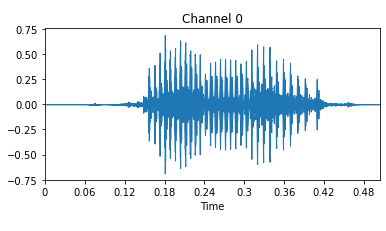

In [55]:
at = AudioTensor.create("あめー雨.mp3")
at.show()

To make a spectrogram in fastaudio the easiest way is to first create a config object with parameters:

In [6]:
cfg = AudioConfig.Voice()

<AxesSubplot:>

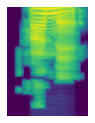

In [56]:
aud2spec = AudioToSpec.from_cfg(cfg)
show_image(aud2spec(at))

I don't know why it comes out flipped, but it's easy to fix

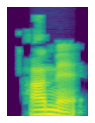

In [6]:
show_image(aud2spec(at)).invert_yaxis()

Let's load a couple of examples to try this configuration on them

In [8]:
ex_paths = [ Path('dict2').ls()[20006],  Path('dict2').ls()[20007],Path('dict1').ls()[21345]]
ex_paths

[Path('dict2/取り残した-473_4_1_male.mp3'),
 Path('dict2/取り残して-473_3_1_female.mp3'),
 Path('dict1/不人気.yomi0003F319_0108.mp3')]

Let's make a function to plot a spectrogram for path with config.

In [9]:
def show_spectro_cfg(cfg, path):
    at = AudioTensor.create(path)
    aud2spec = AudioToSpec.from_cfg(cfg)
    spec = aud2spec(at)
    show_image(spec, figsize=(12,8)).invert_yaxis()
    return spec.shape

torch.Size([1, 128, 397])
torch.Size([1, 128, 460])
torch.Size([1, 128, 532])


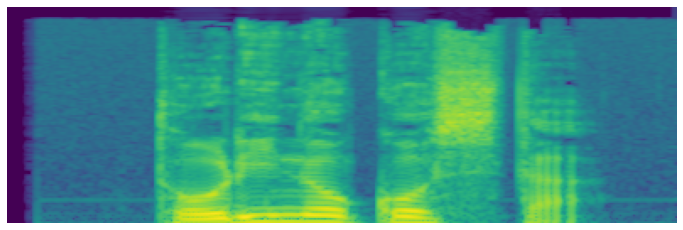

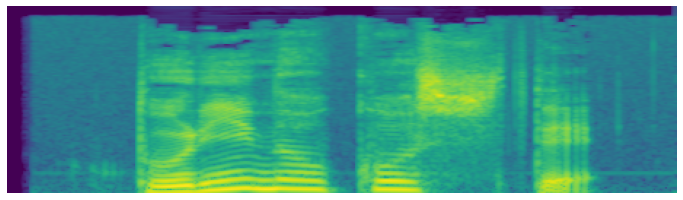

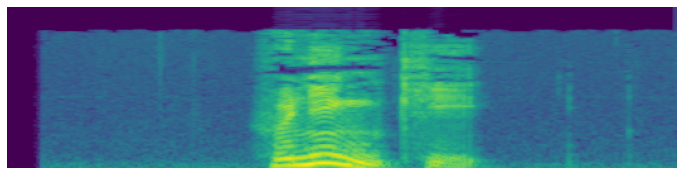

In [10]:
for path in ex_paths:
    print(show_spectro_cfg(cfg, path))

These are good enough and I got to 98% accuracy with them, but let's see if we can do better.

To see what the parameters for `AudioConfig` mean let's look at torchaudio docs.

Edit: [this](https://nbviewer.org/github/fastaudio/fastaudio/blob/master/docs/Introduction%20to%20Audio.ipynb#HyperParameter-Cheat-Sheet) looks like a much better resource.

In [10]:
??torchaudio.transforms.MelSpectrogram

Init signature:
torchaudio.transforms.MelSpectrogram(
    sample_rate: int = 16000,
    n_fft: int = 400,
    win_length: Optional[int] = None,
    hop_length: Optional[int] = None,
    f_min: float = 0.0,
    f_max: Optional[float] = None,
    pad: int = 0,
    n_mels: int = 128,
    window_fn: Callable[..., torch.Tensor] = <built-in method hann_window of type object at 0x7f2703e74d00>,
    power: Optional[float] = 2.0,
    normalized: bool = False,
    wkwargs: Optional[dict] = None,
    center: bool = True,
    pad_mode: str = 'reflect',
    onesided: bool = True,
    norm: Optional[str] = None,
) -> None
Source:        
class MelSpectrogram(torch.nn.Module):
    r"""Create MelSpectrogram for a raw audio signal. This is a composition of Spectrogram
    and MelScale.

    Sources
        * https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe
        * https://timsainb.github.io/spectrograms-mfccs-and-inversion-in-python.html
        * http://haythamfayek.com/2016/04/21/speech-pro

I decided to decrease the upper bound on frequency, since we don't really need the information contained in there for pitch and increase the window size, so as to get better low frequency resolution at the cost of temporal resolution. The rest is heuristics.

In [11]:
pitch_cfg = AudioConfig.Voice(f_min=0, f_max=1200, n_fft=1024*4, win_length=1024*2)

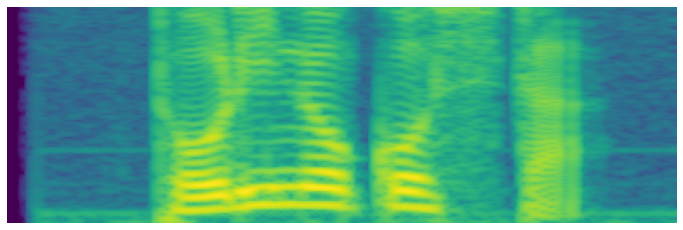

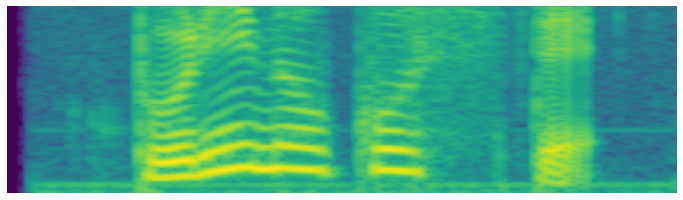

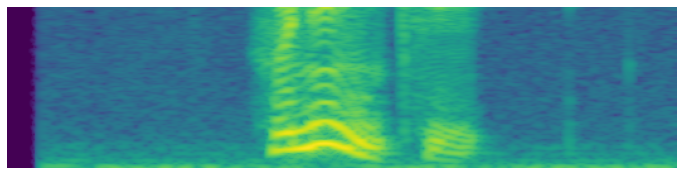

In [12]:
for path in ex_paths:
    show_spectro_cfg(pitch_cfg, path)

I would like to also add minimum decibel cut-off like you can in `torchaudio.transforms.AmplitudeToDB` to add contrast and remove noise, but I wasn't able to find that option if it exists in fastaudio.

## Preparing our labels for training

Let's throw out anything that's not atamadaka, nakadaka or heiban for now.

In [13]:
dict1 = dict1[dict1.pattern.isin(['頭高', '中高', '平板'])]

In [14]:
dict2 = dict2[dict2.pattern.isin(['頭高', '中高', '平板'])]

Add the whole path.

In [15]:
dict1.path = 'dict1/'+dict1.path

In [16]:
dict2.path = 'dict2/'+dict2.path

Merge the labels into one file.

In [17]:
all_labels = pd.concat([dict1, dict2]).reset_index(drop=True)

Convert the labels into romaji, so we can plot the later.

In [18]:
all_labels.pattern.replace(['頭高', '中高', '平板'], ['atamadaka', 'nakadaka', 'heiban'], inplace=True)

Add a column, that we're going to use to split the data into training and validation set.

In [19]:
all_labels['is_valid'] = False

In [20]:
all_labels.loc[all_labels.type == 'dict2 male', 'is_valid'] = True

In [21]:
all_labels

,path,pattern,kana,morae,drop,type,is_valid
0,dict1/ある.yomi000142BB_0596.mp3,atamadaka,アル,2,1,dict1,False
1,dict1/思う.yomi0006C617_043A.mp3,nakadaka,オモウ,3,2,dict1,False
2,dict1/など.yomi000240B7_0028.mp3,atamadaka,ナド,2,1,dict1,False
3,dict1/私.yomi00092F63_0072.mp3,heiban,ワタくシ,4,0,dict1,False
4,dict1/見る.yomi000A41BD_001E.mp3,atamadaka,ミル,2,1,dict1,False
...,...,...,...,...,...,...,...
160758,dict2/立て-377_10_1_female.mp3,atamadaka,たて,2,1,dict2 female,False
160759,dict2/立てる-377_11_1_male.mp3,nakadaka,たてる,3,2,dict2 male,True
160760,dict2/立てる-377_11_1_female.mp3,nakadaka,たてる,3,2,dict2 female,False
160761,dict2/立とう-377_12_1_male.mp3,nakadaka,たとう,3,2,dict2 male,True


Let's take a sample of the data to make quick experiments. 

In [24]:
sample_df = all_labels.sample(16000)

## Making a Learner and training

I'm closely following Zach Mueller's [lesson on audio](https://walkwithfastai.com/Audio) here.

Let's remove the silence from our files (this is going to be most useful at inference), make our data the same size and convert them to spectrograms using the usual configuration.

In [25]:
item_tfms = [RemoveSilence, ResizeSignal(2000), aud2spec]

Preparing the Dataloaders

In [25]:
def get_x(df):
    return df.path
def get_y(df):
    return df.pattern

In [27]:
dblock = DataBlock(blocks=[AudioBlock, CategoryBlock],
                  item_tfms=item_tfms,
                  get_x=get_x,
                  get_y=get_y,
                  splitter=ColSplitter())

In [28]:
dls = dblock.dataloaders(sample_df, shuffle=True)

`AudioSpectrogram.show()` throws out an error for me so I had to hardcode around it by making this function.

In [23]:
def show_spec_batch(dls):
    _,axes = plt.subplots(3,3, figsize=(12,8))
    for (spec, pattern),ax in zip(dls.show_batch(show=False)[2], axes.flatten()):
        show_image(spec, title=pattern, ax=ax).invert_yaxis()

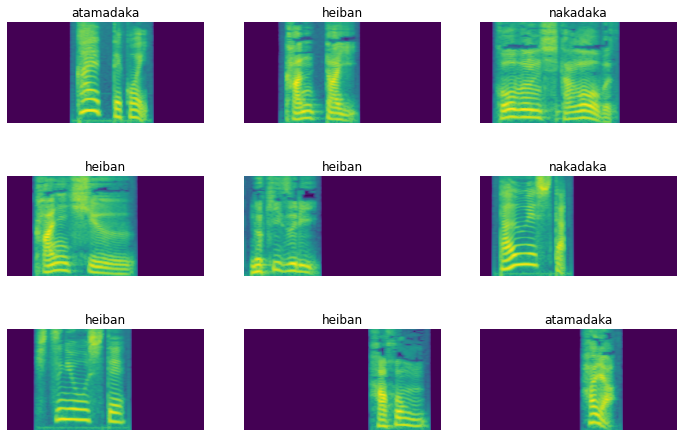

In [30]:
show_spec_batch(dls)

Adding `n_out=3` for the number of classes we have.

In [31]:
learn = Learner(dls, xresnet34(pretrained=True, n_out=3), CrossEntropyLossFlat(), 
                metrics=[accuracy, F1Score(average='weighted')], wd=0.05).to_fp16()

Our spectrograms only have one channel, so we have to change the first Conv Layer.

In [22]:
# learn.model[0][0].in_channels
def alter_learner(learn):
    layer = learn.model[0][0]
    layer.in_channels = 1
    layer.weight = nn.Parameter(layer.weight[:,1,:,:].unsqueeze(1))
    learn.model[0][0] = layer

In [33]:
alter_learner(learn)

In [34]:
learn.unfreeze()

SuggestedLRs(lr_min=0.33113112449646, lr_steep=2.7542285919189453)

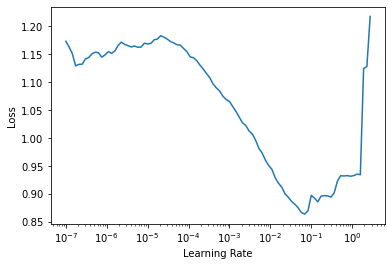

In [35]:
learn.lr_find()

In [36]:
learn.fit_one_cycle(7, 3e-2)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.271414,3.523385,0.625543,0.499470,00:55
1,0.196330,3.277715,0.445437,0.402725,00:52
2,0.155347,0.152431,0.947610,0.945649,00:52
3,0.111935,0.165354,0.934814,0.935485,00:52
4,0.071950,0.171538,0.937711,0.934709,00:52
5,0.051120,0.083185,0.972718,0.972574,00:52
6,0.045892,0.065998,0.976098,0.976093,00:52


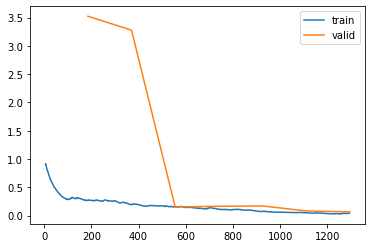

In [37]:
learn.recorder.plot_loss()

Let's make that a function for easier experimenting.

In [24]:
def make_pitch_learner(df, item_tfms, model=xresnet34(pretrained=True, n_out=3)):
    new_dblock = DataBlock(blocks=[AudioBlock, CategoryBlock],
                  item_tfms=item_tfms,
                  get_x=get_x,
                  get_y=get_y,
                  splitter=ColSplitter())
    new_dls = new_dblock.dataloaders(df, shuffle=True)
    new_learn = Learner(new_dls, model, CrossEntropyLossFlat(), 
                metrics=[accuracy, F1Score(average='weighted')], wd=0.05).to_fp16()
    alter_learner(new_learn)
    new_learn.unfreeze()
    return new_learn

Let's try it with the spectrogram parameters we chose.

In [39]:
learn2 = make_pitch_learner(sample_df, [RemoveSilence(), ResizeSignal(2000, AudioPadType.Zeros), 
                                        AudioToSpec.from_cfg(pitch_cfg)])

SuggestedLRs(lr_min=0.19054607152938843, lr_steep=1.5848932266235352)

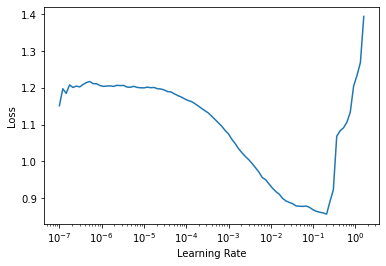

In [40]:
learn2.lr_find()

In [41]:
learn2.fit_one_cycle(7, 3e-2)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.329706,2.352126,0.608402,0.462043,01:22
1,0.206030,0.551953,0.828102,0.829986,01:23
2,0.154101,0.194723,0.952921,0.952699,01:22
3,0.119368,0.105970,0.963061,0.963882,01:22
4,0.091843,0.103478,0.964510,0.964183,01:22
5,0.063340,0.068436,0.975616,0.976229,01:22
6,0.046640,0.060200,0.981169,0.981281,01:22


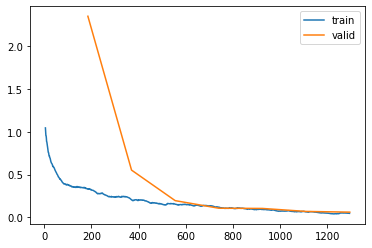

In [42]:
learn2.recorder.plot_loss()

It'd be nice to use `torchaudio.transforms.PitchShift` here, which would force my model to generalize better, but it seems the torchaudio version supported doesn't have that yet.

I tried to implement it on my own, but to no avail.

In [324]:
torchaudio.sox_effects.effect_names() 

['allpass',
 'band',
 'bandpass',
 'bandreject',
 'bass',
 'bend',
 'biquad',
 'chorus',
 'channels',
 'compand',
 'contrast',
 'dcshift',
 'deemph',
 'delay',
 'dither',
 'divide',
 'downsample',
 'earwax',
 'echo',
 'echos',
 'equalizer',
 'fade',
 'fir',
 'firfit',
 'flanger',
 'gain',
 'highpass',
 'hilbert',
 'loudness',
 'lowpass',
 'mcompand',
 'norm',
 'oops',
 'overdrive',
 'pad',
 'phaser',
 'pitch',
 'rate',
 'remix',
 'repeat',
 'reverb',
 'reverse',
 'riaa',
 'silence',
 'sinc',
 'speed',
 'stat',
 'stats',
 'stretch',
 'swap',
 'synth',
 'tempo',
 'treble',
 'tremolo',
 'trim',
 'upsample',
 'vad',
 'vol']

In [55]:
class SoxEffectTransform(torch.nn.Module):
    def __init__(self, effects):
        super().__init__()
        self.effects = effects
        self.rate = 16000
    def forward(self, tensor: torch.Tensor):
        return torchaudio.sox_effects.apply_effects_tensor(
            tensor, self.rate, self.effects)

In [56]:
effects = [ 
     ['pitch', '10'] 
 ]


In [57]:
PitchShift = SoxEffectTransform(effects)

In [58]:
at_shift = PitchShift(at)[0]

In [52]:
torchaudio.sox_effects.init_sox_effects()

In [59]:
Audio(at_shift, rate=24000)

## Final model

So, let's finalize our project by training a bigger model on the whole dataset.

In [26]:
fin_learn = make_pitch_learner(all_labels, [RemoveSilence(), ResizeSignal(2000, AudioPadType.Zeros), 
                                        AudioToSpec.from_cfg(pitch_cfg)], xresnet50(pretrained=True, n_out=3))

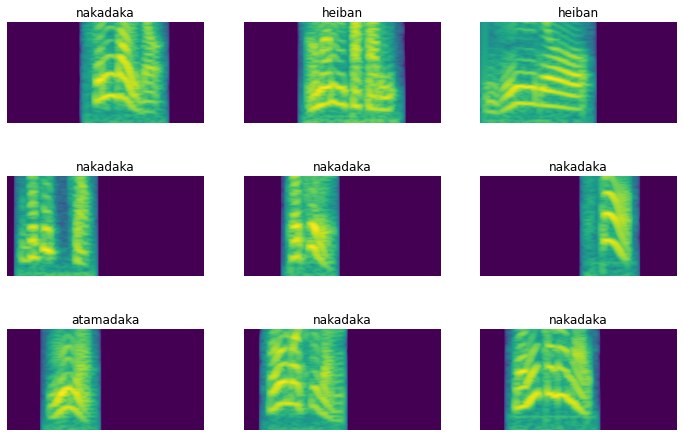

In [27]:
show_spec_batch(fin_learn.dls)

SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=0.3019951581954956)

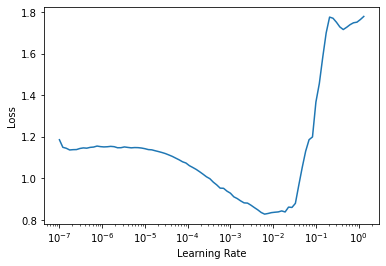

In [28]:
fin_learn.lr_find()

In [29]:
fin_learn.fit_one_cycle(4, 3e-4)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.091439,0.182869,0.930946,0.935078,15:07
1,0.050077,0.076877,0.974457,0.974723,14:16
2,0.033197,0.076989,0.977416,0.977832,13:47
3,0.024043,0.070777,0.979973,0.980235,13:36


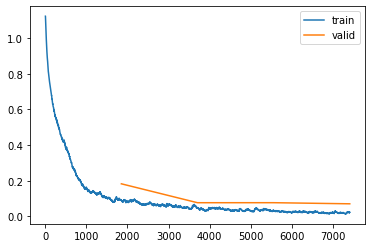

In [30]:
fin_learn.recorder.plot_loss()

In [31]:
fin_learn.export("removesilence_pitch.pkl")

SuggestedLRs(lr_min=3.8196694163161736e-08, lr_steep=8.417093340540305e-06)

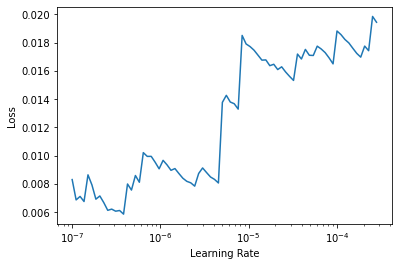

In [35]:
fin_learn.lr_find(end_lr=3e-3)

In [36]:
fin_learn.fit_one_cycle(1, 3e-7)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.023801,0.068112,0.981677,0.981916,13:16


In [37]:
fin_learn.export("removesilence_pitch2.pkl")

In [38]:
fin_learn.fit_one_cycle(1, slice(1e-7, 5e-5))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.022423,0.078075,0.978623,0.978896,13:06


In [49]:
fin_learn.fit_one_cycle(1, slice(1e-7, 5e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.038483,0.059628,0.982719,0.982791,13:55


In [50]:
fin_learn.export('removesilence_pitch3.pkl')

I'm getting pretty desperate here, because I had gotten an accuracy of 0.984 before with the default spectrogram parameters.

In [51]:
fin_learn.fit_one_cycle(1, slice(1e-7, 5e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.029828,0.060020,0.983476,0.983565,13:41


In [52]:
fin_learn.fit_one_cycle(1, slice(1e-8, 1e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.019335,0.059957,0.982932,0.983027,13:36


In [ ]:
fin_learn.fit_one_cycle(1, slice(1e-8, 1e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.026071,0.065069,0.981417,0.981602,13:33


In [ ]:
fin_learn.fit_one_cycle(1, slice(1e-6, 1e-4))

Was my previous model maybe learning some patterns from the phonemes as well?

## Inference

In [58]:
inf_learn = load_learner("removesilence_pitch3.pkl")

Confirming that the saved learner works.

tensor([0.6475, 0.3349, 0.0176]) atamadaka


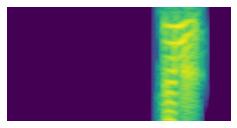

In [78]:
spec,pred,predtens,probs = inf_learn.predict('あめー雨.mp3', with_input=True)
show_image(spec)
print(probs, pred)

tensor([0.3057, 0.6840, 0.0103]) heiban


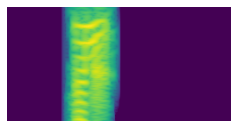

In [81]:
spec,pred,predtens,probs = inf_learn.predict('あめー雨.mp3', with_input=True)
show_image(spec)
print(probs, pred)

This model is not robust, I ended up not using it.

### HuggingFace Space

I used HuggingFace spaces with Gradio to deploy the model.

I created a new space. Then I added a `requirements.txt` file with the following python libraries
```
fastaudio
librosa
soundfile
```

Then after some googling I made a `packages.txt` with the name of a C package `libsndfile1`, that we need for fastaudio to work properly, in it.

Then you create an `app.py` file.

Importing dependencies.

In [ ]:
import gradio as gr
from fastai.vision.all import *
from fastaudio.core.all import *

Loading the learner.

In [ ]:
def get_x(df):
    return df.path

def get_y(df):
    return df.pattern

learn = load_learner('xresnet50_pitch3.pkl')

labels = learn.dls.vocab

We need a function that will return the predictions and a spectrogram from the inputs it gets. We want users to be able to both upload and record audio.

In [ ]:
def predict(Record, Upload):
    if Upload: path = Upload
    else: path = Record
    spec,pred,pred_idx,probs = learn.predict(str(path), with_input=True)
    fig,ax = plt.subplots(figsize=(16,10))
    show_image(spec, ax=ax)
    ax.invert_yaxis()
    return [{labels[i]: float(probs[i]) for i in range(len(labels))}, fig]

So as not to make the spectrogram ourselves once again we pass `with_input=True` to the `predict` method. Gradio's `gr.outputs.Image` can take in a figure from matplotlib, so we create that first.

We return a list with a dictionary for probabilities for the labels and a spectrogram figure.

Preparing other parameters.

In [ ]:
title = "Japanese Pitch Accent Pattern Detector"

description = "This model will predict the pitch accent pattern of a word based on the recording of its pronunciation."

article="<p style='text-align: center'><a href='https://mizoru.github.io/blog' target='_blank'>Blog</a></p>"

examples = [['代わる.mp3'],['大丈夫な.mp3'],['熱くない.mp3'], ['あめー雨.mp3'], ['あめー飴.mp3']]

enable_queue=True

Putting everything into this final call.

In [ ]:
gr.Interface(fn=predict,inputs=[gr.inputs.Audio(source='microphone', type='filepath', optional=True),
                                gr.inputs.Audio(source='upload', type='filepath', optional=True)], 
             outputs=  [gr.outputs.Label(num_top_classes=3), 
                        gr.outputs.Image(type="plot", label='Spectrogram')],
             title=title, description=description, article=article,
             examples=examples).launch(debug=True, enable_queue=enable_queue)